In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from keras import Model, Sequential, layers, regularizers, optimizers
import pickle
from pickle import dump, load
from PIL import Image
from tqdm import tqdm
tqdm().pandas()
from google.cloud import storage
import requests
from io import BytesIO
import random

2024-03-13 18:12:16.647916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 18:12:17.163050: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 18:12:18.573587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 18:12:18.573684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 18:12:18.732162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

import tensorflow

In [33]:
storage_client = storage.Client("wagon-bootcamp-415720")
bucket = storage_client.get_bucket('covid19_lewagon')
blob = bucket.blob("COVID-19_Radiography_Dataset/Covid/COVID-1.png")
blob._get_download_url(storage_client)

'https://storage.googleapis.com/download/storage/v1/b/covid19_lewagon/o/COVID-19_Radiography_Dataset%2FCovid%2FCOVID-1.png?alt=media'

In [4]:
def download_bucket_with_transfer_manager(
    bucket_name, destination_directory="", workers=8, max_results=1000
):
    from google.cloud.storage import Client, transfer_manager

    storage_client = Client()
    bucket = storage_client.bucket(bucket_name)

    blob_names = [blob.name for blob in bucket.list_blobs(max_results=max_results)]

    results = transfer_manager.download_many_to_path(
        bucket, blob_names, destination_directory=destination_directory, max_workers=workers
    )

    for name, result in zip(blob_names, results):
        # The results list is either `None` or an exception for each blob in
        # the input list, in order.

        if isinstance(result, Exception):
            print("Failed to download {} due to exception: {}".format(name, result))
        else:
            print("Downloaded {} to {}.".format(name, destination_directory + name))

In [5]:
#download_bucket_with_transfer_manager(
#    'covid19_lewagon', destination_directory="/home/user/code/gulfairus/Covid19/raw_data/cloud", workers=8, max_results=25500
#)

Downloaded COVID-19_Radiography_Dataset/COVID/COVID-1.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-1.png.
Downloaded COVID-19_Radiography_Dataset/COVID/COVID-10.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-10.png.
Downloaded COVID-19_Radiography_Dataset/COVID/COVID-100.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-100.png.
Downloaded COVID-19_Radiography_Dataset/COVID/COVID-1000.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-1000.png.
Downloaded COVID-19_Radiography_Dataset/COVID/COVID-1001.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-1001.png.
Downloaded COVID-19_Radiography_Dataset/COVID/COVID-1002.png to /home/user/code/gulfairus/Covid19/raw_data/cloudCOVID-19_Radiography_Dataset/COVID/COVID-1002.png.
Downloaded COVID-19_Radiography_Da

In [5]:

main_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/COVID-19_Radiography_Dataset"
covid = os.path.join(main_dir, "COVID")
normal = os.path.join(main_dir, "Normal")
pneumonia = os.path.join(main_dir, "Viral Pneumonia")
opacity = os.path.join(main_dir, "Lung_Opacity")
covid_names = os.listdir(covid)
normal_names = os.listdir(normal)
pneumonia_names = os.listdir(pneumonia)
opacity_names = os.listdir(opacity)
print(len(covid_names))
print(len(normal_names))
print(len(pneumonia_names))
print(len(opacity_names))
print(len(covid_names)+len(normal_names)+len(pneumonia_names)+len(opacity_names))

4319
10192
4763
6012
25286


## Train test split

In [9]:
random.shuffle(covid_names)
random.shuffle(normal_names)
random.shuffle(pneumonia_names)
random.shuffle(opacity_names)
train_covid_names, test_covid_names = train_test_split(covid_names, test_size=0.20, random_state=42)
train_normal_names, test_normal_names = train_test_split(normal_names, test_size=0.20, random_state=42)
train_pneumonia_names, test_pneumonia_names = train_test_split(pneumonia_names, test_size=0.20, random_state=42)
train_opacity_names, test_opacity_names = train_test_split(opacity_names, test_size=0.20, random_state=42)

In [10]:
print(len(train_covid_names), len(test_covid_names))
print(len(train_normal_names), len(test_normal_names))
print(len(train_pneumonia_names), len(test_pneumonia_names))
print(len(train_opacity_names), len(test_opacity_names))

3455 864
8153 2039
3810 953
4809 1203


## Create folders Train, Test and save images inside these folders

In [14]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud"
os.mkdir(cloud_dir + '/' + "train_test")

In [16]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test"
os.mkdir(cloud_dir + '/' + "train")

In [20]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
os.mkdir(cloud_dir + '/' + "COVID19")
for img_name in tqdm(train_covid_names):
    img = Image.open(os.path.join(covid, img_name))
    img = img.convert('RGB')
    img.save(cloud_dir+"/COVID19/"+img_name)

  0%|          | 0/3455 [00:00<?, ?it/s]

100%|██████████| 3455/3455 [04:49<00:00, 11.93it/s] 


In [22]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
os.mkdir(cloud_dir + '/' + "NORMAL")
for img_name in tqdm(train_normal_names):
    img = Image.open(os.path.join(normal, img_name))
    img.save(cloud_dir+"/NORMAL/"+img_name)

100%|██████████| 8153/8153 [02:46<00:00, 48.82it/s]


In [23]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
os.mkdir(cloud_dir + '/' + "PNEUMONIA")
for img_name in tqdm(train_pneumonia_names):
    img = Image.open(os.path.join(pneumonia, img_name))
    img.save(cloud_dir+"/PNEUMONIA/"+img_name)

100%|██████████| 3810/3810 [01:19<00:00, 47.72it/s]


In [24]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
os.mkdir(cloud_dir + '/' + "OPACITY")
for img_name in tqdm(train_opacity_names):
    img = Image.open(os.path.join(opacity, img_name))
    img.save(cloud_dir+"/OPACITY/"+img_name)

100%|██████████| 4809/4809 [01:12<00:00, 66.35it/s]


In [25]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test"
os.mkdir(cloud_dir + '/' + "test")

In [27]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"
os.mkdir(cloud_dir + '/' + "COVID19")
for img_name in tqdm(test_covid_names):
    img = Image.open(os.path.join(covid, img_name))
    img = img.convert('RGB')
    img.save(cloud_dir+"/COVID19/"+img_name)

100%|██████████| 864/864 [00:19<00:00, 44.32it/s]


In [28]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"
os.mkdir(cloud_dir + '/' + "NORMAL")
for img_name in tqdm(test_normal_names):
    img = Image.open(os.path.join(normal, img_name))
    img.save(cloud_dir+"/NORMAL/"+img_name)

100%|██████████| 2039/2039 [00:28<00:00, 72.69it/s]


In [29]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"
os.mkdir(cloud_dir + '/' + "PNEUMONIA")
for img_name in tqdm(test_pneumonia_names):
    img = Image.open(os.path.join(pneumonia, img_name))
    img.save(cloud_dir+"/PNEUMONIA/"+img_name)

100%|██████████| 953/953 [00:15<00:00, 59.98it/s]


In [30]:
cloud_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"
os.mkdir(cloud_dir + '/' + "OPACITY")
for img_name in tqdm(test_opacity_names):
    img = Image.open(os.path.join(opacity, img_name))
    img.save(cloud_dir+"/OPACITY/"+img_name)

100%|██████████| 1203/1203 [00:18<00:00, 64.21it/s]


In [6]:
project_id = 'wagon-bootcamp-415720'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://covid19_lewagon/
gs://taxifare_gulfairus/


In [8]:
bucket_name = 'covid19_lewagon'
!gsutil -m cp -r /home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/* gs://{bucket_name}/train_test/train

Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-3530.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/96da829b.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-2170.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-1510.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-3165.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-812.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID19(214).jpg [Content-Type=image/jpeg]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/t

In [9]:
bucket_name = 'covid19_lewagon'
!gsutil -m cp -r /home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/* gs://{bucket_name}/train_test/test

Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID19(271).jpg [Content-Type=image/jpeg]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-2500.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-2110.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-1315.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-2537.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-3549.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/COVID19/COVID-162.png [Content-Type=image/png]...
Copying file:///home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test/C

## Visualization

In [39]:
train_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
test_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"


train_covid_dir = os.path.join(train_dir, "COVID19")
train_normal_dir = os.path.join(train_dir, "NORMAL")
train_pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")
train_opacity_dir = os.path.join(train_dir, "OPACITY")
#directory with the testing images
test_covid_dir = os.path.join(test_dir, "COVID19")
test_normal_dir = os.path.join(test_dir, "NORMAL")
test_pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
test_opacity_dir = os.path.join(test_dir, "OPACITY")

['/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-1134.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-1827.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-1743.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/COVID19/COVID-1905.png']
['/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/NORMAL/Normal-1204.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/NORMAL/Normal-7364.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/NORMAL/Normal-5117.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/NORMAL/Normal-9547.png']
['/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/PNEUMONIA/Viral Pneumonia-350.png', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train/PNEUMONIA/PNEUMONIA(1573).jpg', '/home/user/code/gulfairus/Covid19/raw_data/cloud/train_tes

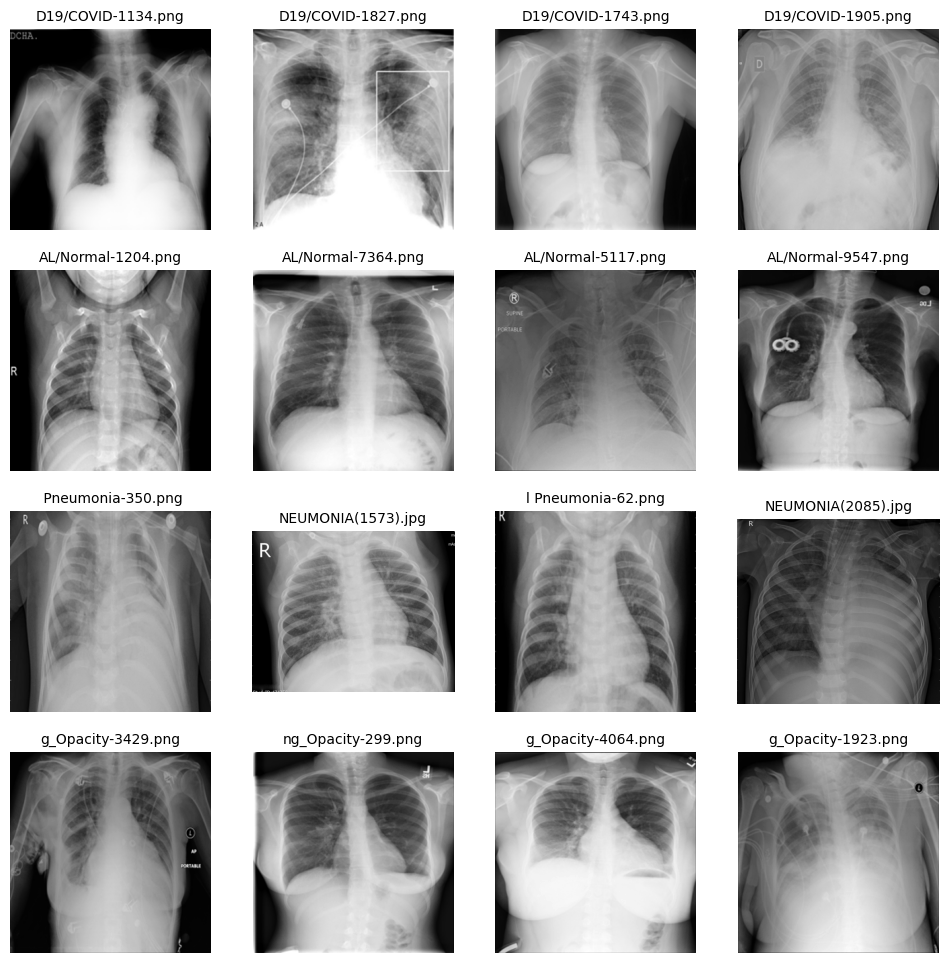

In [40]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
import matplotlib.image as mpimg

#set the number of columns and rows
rows = 4
cols = 4

#set the figure size
fig = plt.gcf()
fig.set_size_inches(12,12)

#get the filenames from the covid & normal dir of the train dataset
covid_pic = [os.path.join(train_covid_dir, filename) for filename in train_covid_names[0:4]]
normal_pic = [os.path.join(train_normal_dir, filename) for filename in train_normal_names[0:4]]
pneumonia_pic = [os.path.join(train_pneumonia_dir, filename) for filename in train_pneumonia_names[0:4]]
opacity_pic = [os.path.join(train_opacity_dir, filename) for filename in train_opacity_names[0:4]]
#print the list
print(covid_pic)
print(normal_pic)
print(pneumonia_pic)
print(opacity_pic)
#merge the covid and normal list
merged_list = covid_pic+normal_pic+pneumonia_pic+opacity_pic
for i, img_path in enumerate(merged_list):
  data = img_path.split("/",6)[6]
  sp = plt.subplot(rows, cols, i+1)
  sp.axis("off")
  img = mpimg.imread(img_path)
  sp.set_title(data[-18:], fontsize=10)
  plt.imshow(img, cmap="gray")
plt.show()

## Data Preprocessing & Augmentation

In [2]:
# generate training,testing and validation batches
train_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/train"
test_dir = "/home/user/code/gulfairus/Covid19/raw_data/cloud/train_test/test"

dgen_train = ImageDataGenerator(#samplewise_center=True,
                                #samplewise_std_normalization=True,
                                rescale = 1./255,
                                validation_split=0.2,
                                #rotation_range=20,
                                shear_range=0.2,
                                zoom_range = 0.2,
                                horizontal_flip = False)
dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale=1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset = "training",
                                                 batch_size = 32,
                                                 class_mode = "categorical")

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset = "validation",
                                                 batch_size = 32,
                                                 class_mode = "categorical")

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(150,150),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 16183 images belonging to 4 classes.
Found 4044 images belonging to 4 classes.
Found 5059 images belonging to 4 classes.


In [13]:
BUCKET_NAME = 'covid19_lewagon'
client = storage.Client()
blobs = list(client.get_bucket(BUCKET_NAME).list_blobs(prefix="train_test/train"))

In [15]:
blobs.
https://storage.cloud.google.com/covid19_lewagon/train_test/train/COVID19/006f3a8a.png

[<Blob: covid19_lewagon, train_test/train/, 1710207020606516>,
 <Blob: covid19_lewagon, train_test/train/COVID19/006f3a8a.png, 1710209003782848>,
 <Blob: covid19_lewagon, train_test/train/COVID19/00870a9c.png, 1710208883026381>,
 <Blob: covid19_lewagon, train_test/train/COVID19/00d96e05.png, 1710208903055611>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0578e08b.png, 1710208882712126>,
 <Blob: covid19_lewagon, train_test/train/COVID19/08d780ae.png, 1710209036513874>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0957ce54.png, 1710208933020397>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0a7faa2a.png, 1710208835011423>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0ac7580d.png, 1710208992088567>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0cd9fcb6.png, 1710208988796043>,
 <Blob: covid19_lewagon, train_test/train/COVID19/0cea09eb.png, 1710209035995788>,
 <Blob: covid19_lewagon, train_test/train/COVID19/1479fa94.png, 1710208924327353>,
 <Blob: covid19_lewagon,

In [3]:
X_train, y_train = train_generator.next()
X_val, y_val = validation_generator.next()
X_test, y_test = test_generator.next()

In [4]:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'OPACITY': 2, 'PNEUMONIA': 3}

In [3]:
model = Sequential()
model.add(Conv2D(32,(5,5), padding="SAME", activation="relu", input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(32,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(32,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(32,(5,5), padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(64,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(64,(5,5), padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(128,(5,5), padding="SAME", activation="relu"))
model.add(Conv2D(128,(5,5), padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005), activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        25632     
                                                        

In [7]:
reg = regularizers.l2(0.005)

model = Sequential()
model.add(Conv2D(256,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu", input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(128,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(128,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(64,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(64,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(32,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(32,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(Conv2D(32,(5,5), kernel_regularizer=reg, bias_regularizer=reg, padding="SAME", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=reg, bias_regularizer=reg, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_regularizer=reg, bias_regularizer=reg, activation="softmax"))

print("✅ Model initialized")
print(model.summary)

✅ Model initialized
<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f153a7957e0>>


In [5]:
model.compile(Adam(learning_rate=0.0001), loss="squared_hinge", metrics=["accuracy"])

In [6]:
#train the model
#os.mkdir(main_dir + '/' + "models")
#os.mkdir(main_dir + '/' + "history")
epochs = 5
batch_size = 3
#steps = len(train_names)//batch_size

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data = validation_generator)
# model.save(main_dir + '/' + "models/model1" + ".h5")
# with open(main_dir + '/' + "history/history1" + ".p", 'wb') as file_pi:
#   pickle.dump(history.history, file_pi)
#for i in range(epochs):
#    history=model.fit_generator(train_generator, epochs=1, steps_per_epoch= steps, verbose=1,
#                                validation_data = validation_generator)
#    model.save(main_dir + '/' + "models/model_" + str(i) + ".h5")
#    #history_xception.save(main_dir + '/' + "history/history" + str(i) + ".h5")
#    with open(main_dir + '/' + "history/history_" + str(i) + ".p", 'wb') as file_pi:
#      pickle.dump(history.history, file_pi)

Epoch 1/5
 11/506 [..............................] - ETA: 5:01:24 - loss: 1.3343 - accuracy: 0.3750

IOStream.flush timed out


In [ ]:
model = load_model(main_dir + '/' + "models/model1.h5")

In [ ]:
#get the keys of history object
history.history.keys()

In [ ]:
#plot graph between training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Training and validation losses")
plt.xlabel("epoch")

In [ ]:

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Training", "Validation"])
plt.title("Training and validation accuracy")
plt.xlabel("epoch")

In [ ]:
# get the test acuarcy and loss
test_loss, test_acc = model.evaluate(test_generator)
print("test loss :{} test acc : {}".format(test_loss,test_acc))

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Model, load_model

main_dir = "/content/drive/My Drive/data/viral/COVID-19_Radiography_Dataset/"
model = load_model(main_dir + '/' + "models/model.h5")

uploaded = files.upload()
for filename in uploaded.keys():
  img_path = "/content/drive/My Drive/data/viral/covid_examples/"+filename
  img = image.load_img(img_path, target_size=(150,150))
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  print(filename)
  print(prediction)
  #if prediction == 0:
  #  print("covid19 detected")
  #else:
  #  print("Your report is normal")